In [2]:
# our first graph 

from typing import Dict, TypedDict
from langgraph.graph import  StateGraph 

In [3]:
# Let's create a Agent state 

class AgentState(TypedDict): 
    message : str 

def greeting_node(state: AgentState)-> AgentState: 
    """Simple node that adds a greeting message to the state"""

    state["message"] = "Hey " + state["message"] + ", how is your day going"

    return state


In [4]:
graph = StateGraph(AgentState)
graph.add_node("greeter", greeting_node)
graph.set_entry_point("greeter")
graph.set_finish_point("greeter")

app = graph.compile()


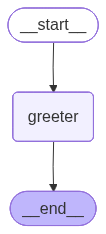

In [6]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [7]:
result = app.invoke({"message": "Bob"})

result["message"]

'Hey Bob, how is your day going'

In [8]:
# Graph 2 
from typing import TypedDict, List
from langgraph.graph import StateGraph


class AgentState(TypedDict): 
    values : List[int]
    name: str
    result: str 


In [9]:
def process_values(state: AgentState) -> AgentState: 
    "This function handles multiple different inputs"
    print(state)
    state["result"] = f"Hi there {state['name']} !, Your sum = {sum(state["values"])}"
    print(state)

    return state



In [10]:
graph = StateGraph(AgentState)
graph.add_node("processor", process_values)
graph.set_entry_point("processor")
graph.set_finish_point("processor")
app = graph.compile()

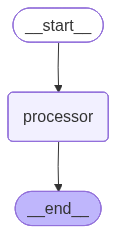

In [11]:
from IPython.display import Image, display 
display(Image(app.get_graph().draw_mermaid_png()))

In [12]:
answer = app.invoke({
    "values": [1, 2, 3, 4], 
    "name": "Steve"
})

{'values': [1, 2, 3, 4], 'name': 'Steve'}
{'values': [1, 2, 3, 4], 'name': 'Steve', 'result': 'Hi there Steve !, Your sum = 10'}


In [13]:
answer["result"]

'Hi there Steve !, Your sum = 10'

In [14]:
# Sequential Agent 

# Graph 3 

from typing import TypedDict
from langgraph.graph import StateGraph


In [15]:
class AgentState(TypedDict): 
    name: str 
    age: str 
    final: str 

In [16]:
def first_node(state: AgentState) -> AgentState: 
    """This is the first node of our sequence"""
    state["final"] = f"Hi {state["name"]}"
    return state 



def second_node(state: AgentState) -> AgentState: 
    "This is the second node of our sequence"
    state["final"] += f" you are {state["age"]} years old!"
    return state 



In [17]:
graph = StateGraph(AgentState) 
graph.add_node("first_node", first_node)
graph.add_node("second_node", second_node)

graph.set_entry_point("first_node")
graph.add_edge("first_node", "second_node") # adding edge from first node --> second node 
graph.set_finish_point("second_node")

app = graph.compile()

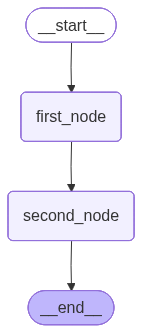

In [18]:
from IPython.display import Image, display 
display(Image(app.get_graph().draw_mermaid_png()))

In [20]:
result = app.invoke({
    "name": "Charlie", 
    "age": 20
})

print(result)

{'name': 'Charlie', 'age': 20, 'final': 'Hi Charlie you are 20 years old!'}


In [21]:
# conditional agent 

from typing import TypedDict 
from langgraph.graph import StateGraph, START, END 

class AgentState(TypedDict): 
    number1: int 
    operation: str 
    number2: int 
    finalNumber : int 

    

In [22]:
def adder(state: AgentState) -> AgentState: 
    """This nodde adds the 2 numbers"""
    state["finalNumber"] = state["number1"] + state["number2"]
    return state 



def substractor(state: AgentState) -> AgentState: 
    """This node substract the 2 numbers"""
    state["finalNumber"] = state["number1"] - state["number2"]
    return state 


def decide_next_node(state: AgentState) -> AgentState:
    """This node will be select next"""
    if state["operation"]=="+": 
        return "addition_operation"

    elif state["operation"] == "-": 
        return "substraction_operation" 

In [28]:
graph = StateGraph(AgentState)
graph.add_node("add_node", adder)
graph.add_node("substract_node", substractor)
graph.add_node("router", lambda state: state)
graph.add_edge(START, "router")

graph.add_conditional_edges(
    "router", 
    decide_next_node, 
    {
        "addition_operation": "add_node", 
        "substraction_operation": "substract_node"
    }
)
graph.add_edge("add_node", END)
graph.add_edge("substract_node", END)

app = graph.compile()

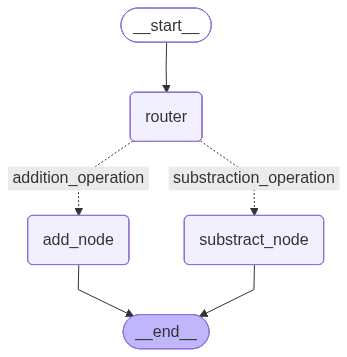

In [29]:
from IPython.display import Image, display 

display(Image(app.get_graph().draw_mermaid_png()))

In [30]:
initial_state_1 = AgentState(number1=10, operation="+", number2=2)

print(app.invoke(initial_state_1))

{'number1': 10, 'operation': '+', 'number2': 2, 'finalNumber': 12}


In [31]:
## Looping 

from langgraph.graph import StateGraph, END 
import random 
from typing import Dict, List, TypedDict 


In [32]:
class AgentState(TypedDict): 
    name: str 
    number: List[int]
    counter: int 


def greeting_node(state: AgentState) -> AgentState: 
    """Greeting Node which says hi to the person"""
    state["name"] = f"Hi there, {state["name"]}"
    state["counter"] = 0 


def random_node(state: AgentState) -> AgentState: 
    """Generates a random number from 0 to 10"""
    state["number"].append(random.randint(0, 10))
    state["counter"] += 1 
    return state 


def should_continue(state: AgentState) -> AgentState: 
    """Function to decide what to do next"""
    if state["counter"] < 5: 
        print("Entering LOOP", state["counter"])
        return "loop"
    
    else : return "exit"

In [35]:
graph = StateGraph(AgentState)
graph.add_node('greeting_node', greeting_node)
graph.add_node("random_node", random_node)
graph.add_edge("greeting_node", "random_node")

graph.add_conditional_edges(
    "random_node", 
    should_continue, 
    {
        "loop": "random_node", 
        "exit": END
    }
)

graph.set_entry_point("greeting_node")
app = graph.compile()

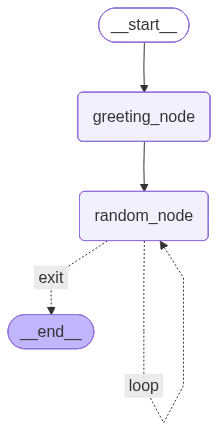

In [36]:
from IPython.display import Image, display 
display(Image(app.get_graph().draw_mermaid_png()))

In [40]:
app.invoke(
    {
        "name": "Rushikesh", 
        "number": [], 
        "counter":6
    }
)

{'name': 'Rushikesh', 'number': [7], 'counter': 7}